<a href="https://colab.research.google.com/github/PavanKumarDharmoju/Electricity-Load-Prediction-Using-LSTM/blob/main/Linear_Regression_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MULTIVARIATE LINEAR REGRESSION MODEL
###IMPORTING PACKAGES AND DATASET

In [ ]:
#importing necessary packages 
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from datetime import datetime

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
import math
print(tf.__version__)
from keras.metrics import mean_squared_error

2.4.1


In [ ]:
#To upload CSV file from device
from google.colab import files
data_to_load = files.upload()


Saving FinalProject to FinalProject


###LOADING DATA

In [ ]:
# load dataset
dataset = pd.read_csv('FinalProject', header=0, index_col=0)

###SPLITTING AND VISUALISING DATASET

In [ ]:
#Split the data into train and test
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

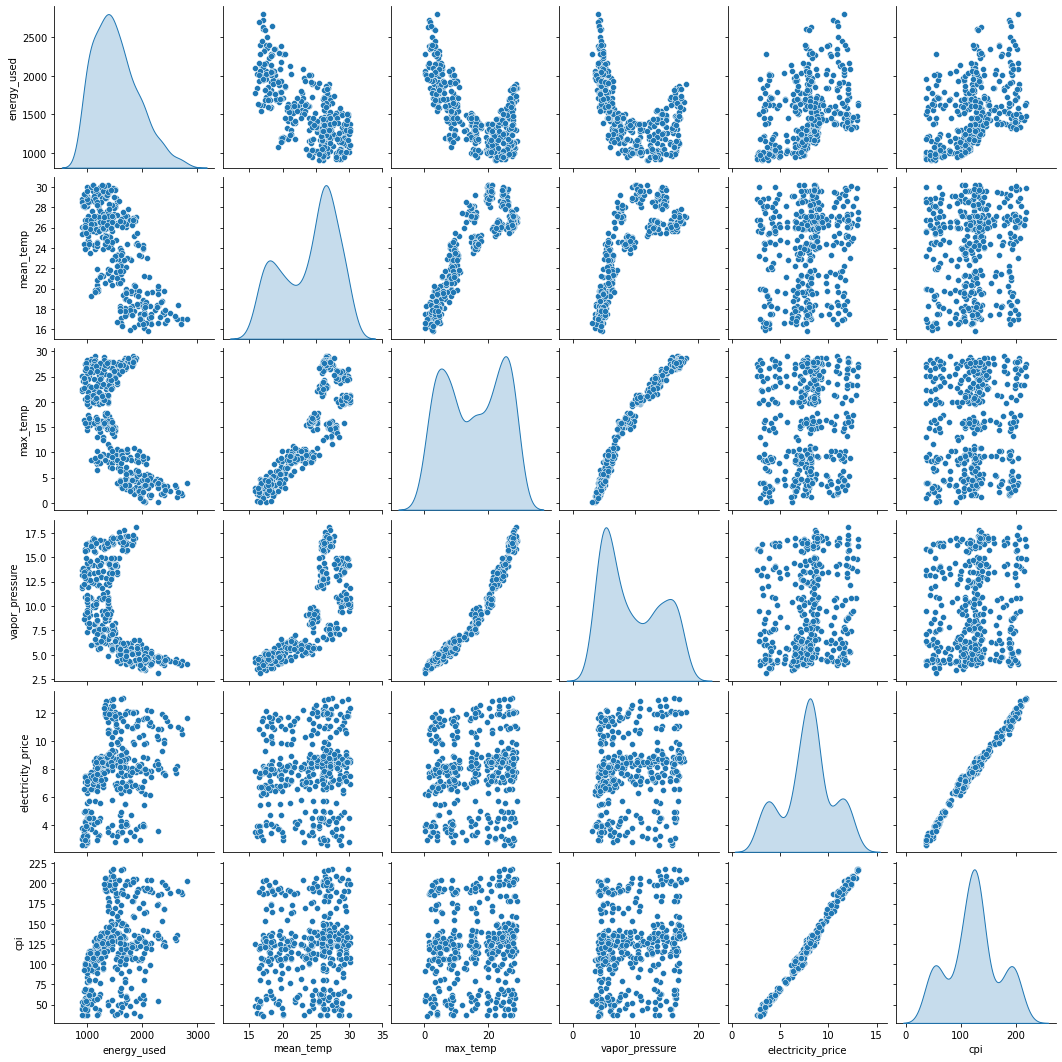

In [ ]:
#Have a quick look at the joint distribution of a few pairs of columns from the training set.
sns.pairplot(train_dataset[['energy_used', 'mean_temp', 'max_temp','vapor_pressure','electricity_price', 'cpi']], diag_kind='kde')

In [ ]:
#Look at the overall statistics, to see how each feature covers a very different range:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
energy_used,403.0,1521.400521,401.375481,901.7,1200.7025,1453.616,1775.467,2808.419
mean_temp,403.0,23.993300,4.113209,15.8,20.0000,25.500,27.050,30.200
max_temp,403.0,15.388586,9.140703,0.1,6.7500,15.800,24.450,29.100
vapor_pressure,403.0,9.465509,4.514485,3.1,5.3000,8.200,13.750,18.100
electricity_price,403.0,7.888362,2.518321,2.6,6.7150,8.060,8.975,13.090
cpi,403.0,123.039623,45.347547,36.5,99.4000,124.000,142.900,217.930


In [ ]:
#Split features from labels

train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('energy_used')
test_labels = test_features.pop('energy_used')

###NORMALISATION

In [ ]:
#In the table of statistics it's easy to see how different the ranges of each feature are.
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
energy_used,1521.400521,401.375481
mean_temp,23.993300,4.113209
max_temp,15.388586,9.140703
vapor_pressure,9.465509,4.514485
electricity_price,7.888362,2.518321
cpi,123.039623,45.347547


In [ ]:
#The Normalization layer
normalizer = preprocessing.Normalization()
#Then .adapt() it to the data:
normalizer.adapt(np.array(train_features))
#calculates the mean and variance, and stores them in the layer
print(normalizer.mean.numpy())

[ 23.9933     15.388586    9.465508    7.8883624 123.03962  ]


In [ ]:
#When the layer is called it returns the input data, with each feature independently normalized
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[26.5 29.  16.8  5.7 80. ]]

Normalized: [[ 0.61  1.49  1.63 -0.87 -0.95]]


##BUILDING MODEL

In [ ]:
#You can use a setup to make predictions based on multiple inputs. This model does the same
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

In [ ]:
#When you call this model on a batch of inputs, it produces units=1 outputs for each example.
linear_model.predict(train_features[:10])

array([[-0.73160845],
       [-1.5080752 ],
       [ 2.8030903 ],
       [ 0.13312656],
       [ 0.9059509 ],
       [-3.1617126 ],
       [ 0.896664  ],
       [ 2.1706362 ],
       [-0.94334275],
       [-0.3653013 ]], dtype=float32)

In [ ]:
#When you call the model it's weight matrices will be built. Now you can see that the kernel
linear_model.layers[1].kernel

<tf.Variable 'dense_1/kernel:0' shape=(5, 1) dtype=float32, numpy=
array([[-0.40456557],
       [ 0.2773037 ],
       [ 0.28080916],
       [ 0.60827446],
       [ 0.8689463 ]], dtype=float32)>

In [ ]:
#Once the model is built, configure the training procedure using the Model.compile() method
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.8),
    loss='mean_squared_error')

In [ ]:
#Once the training is configured, use Model.fit() to execute the training:
%%time
history = linear_model.fit(
    train_features, train_labels, validation_split=0.2,
    epochs=1000,
    # suppress logging
    verbose=0)
print(history)

CPU times: user 1min 16s, sys: 2.2 s, total: 1min 19s
Wall time: 1min 15s


In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label= 'val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error [energy_used]')
  plt.legend()
  plt.grid(True)

##CHECKING ERROR

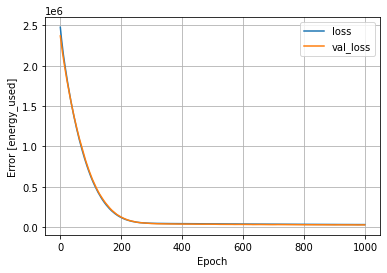

In [ ]:
plot_loss(history)

In [ ]:
#Collect the results on the test set, for later:
test_results = {}

test_results['mse'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)

test_results['rmse'] = np.sqrt(test_results['mse'])

In [ ]:
pd.DataFrame(test_results, index=['Error']).T

,Error
mse,28038.117188
rmse,167.445863
